# Tampa Real-Estate Recommender
## Feature Engineering
TB Real Estate Corporation is a real estate investment firm in the Tampa Bay, Florida area.  The real estate market in the Tampa Bay area is very active.  Single family homes are selling quickly.  TB Real Estate Corporation needs to be able to assess the value of homes coming onto the market quickly and accurately so that they can beat the competition in making a competitive offer.   They need to be able to evaluate the listing price against the predicted sale price in order to identify properties that may be priced below market value and would make good investments.  
<br>
The objective of the Feature Engineering is to prepare the features and to build training and testing datasets to optimally support the machine learning models in order to predict the sales price for residential properties.

# 1 Imports and File Locations<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

# 2 Read Sales data into dataframe<a id='2'></a>

In [3]:
df = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object}, parse_dates=['S_DATE'])
df.info()

C:\Users\mkars\AppData\Local\Temp\ipykernel_10500\1819962950.py:1: DtypeWarning: Columns (26,27,28,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object}, parse_dates=['S_DATE'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847102 entries, 0 to 847101
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   FOLIO            847102 non-null  object        
 1   DOR_CODE         847102 non-null  object        
 2   S_DATE           847102 non-null  datetime64[ns]
 3   VI               847102 non-null  object        
 4   QU               847102 non-null  object        
 5   REA_CD           847102 non-null  object        
 6   S_AMT            847102 non-null  float64       
 7   S_TYPE           847102 non-null  object        
 8   ORIG_SALES_DATE  847102 non-null  object        
 9   SITE_ADDR        847013 non-null  object        
 10  SITE_CITY        847095 non-null  object        
 11  SITE_ZIP         847102 non-null  object        
 12  tBEDS            847102 non-null  float64       
 13  tBATHS           847102 non-null  float64       
 14  tSTORIES         847

# 3 Train-Test Split<a id='3'></a>

In [4]:
# Extract independent feature variables to X
features = ['DOR_CODE', 'S_DATE', 'VI', 'ACT', 'tBEDS', 'tBATHS', 'tSTORIES', 'tUNITS', 'tBLDGS', 'NBHC', 'JUST', 'HEAT_AR', 'ACREAGE']
X = df[features] 

In [5]:
# Extract target dependent variable to y
y = df.S_AMT

In [6]:
# Call train_test_split on X, y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # Create Market Area and One-Hot Encode
df['MARKET_AREA_CD'] = df['NBHC'].astype(str).str[1:3]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(677681, 13) (677681,)
(169421, 13) (169421,)


# 4 Feature Engineering<a id='4'></a>

In [7]:
def feature_eng(df_X):
    """ Perform Feature Engineering on X dataframe 
    """
    # Replace DOR_CODE with text values for One-Hot Encoding
    df_X['DOR_CODE'].replace({'0100': 'single_family_home', 
                              '0102': 'sf_mobile_home', 
                              '0106': 'townhouse', 
                              '0200': 'mobile_home',
                              '0400': 'condo',
                              '0408': 'condo_mh',
                              '0800': 'multi_family_home',
                              '0801': 'multi_family_home'
                             }, inplace=True)
    df_X['DOR_CODE'].replace(regex=r'^[0-9]*$', value='other', inplace=True)
    
    # Replace S_DATE with integer sales date epoch
    df_X['sales_date_epoch'] = (df_X['S_DATE'] - dt.datetime(1970,1,1)).dt.days
    
    # Replace VI with boolean for Improved vs.Vacant
    df_X['improved'] = np.where(df_X['VI']=='I',True,False)
    
    # Calculate the age of the home in years
    df_X['age_of_home'] = df_X['S_DATE'].dt.year - df_X['ACT']
    
    # Create Market Area for One-Hot Encoding
    df_X['market_area_cd'] = df_X['NBHC'].astype(str).str[1:3]

    # Drop features that have been converted
    df_X.drop(['S_DATE', 'VI', 'ACT', 'NBHC'], axis=1, inplace=True)
    
    # One-Hot Encode categorical features
    df_X = pd.get_dummies(df_X, columns=['DOR_CODE', 'market_area_cd'], prefix=['TYPE', 'MKT_AREA'])
    
    return df_X

In [8]:
X_train = feature_eng(X_train)

In [9]:
X_test = feature_eng(X_test)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(677681, 47) (677681,)
(169421, 47) (169421,)


In [11]:
features = X_train.columns
X_train.head()

,tBEDS,tBATHS,tSTORIES,tUNITS,tBLDGS,JUST,HEAT_AR,ACREAGE,sales_date_epoch,improved,...,MKT_AREA_20,MKT_AREA_21,MKT_AREA_22,MKT_AREA_23,MKT_AREA_24,MKT_AREA_25,MKT_AREA_26,MKT_AREA_27,MKT_AREA_28,MKT_AREA_29
391468,1.0,1.0,1.0,1.0,1.0,164119.0,677.0,0.393838,6605,True,...,1,0,0,0,0,0,0,0,0,0
616034,4.0,3.0,1.0,1.0,1.0,398190.0,2789.0,0.196832,17295,True,...,0,0,0,0,0,1,0,0,0,0
267946,2.0,2.0,1.0,1.0,1.0,275473.0,1459.0,0.548202,6543,True,...,0,0,0,0,0,0,0,0,0,0
310113,3.0,2.0,1.0,1.0,1.0,276698.0,1685.0,0.333429,12429,True,...,0,0,0,0,0,0,0,1,0,0
709399,2.0,2.5,2.0,1.0,0.0,190025.0,1191.0,0.030083,12891,True,...,0,0,0,0,0,0,0,0,0,0


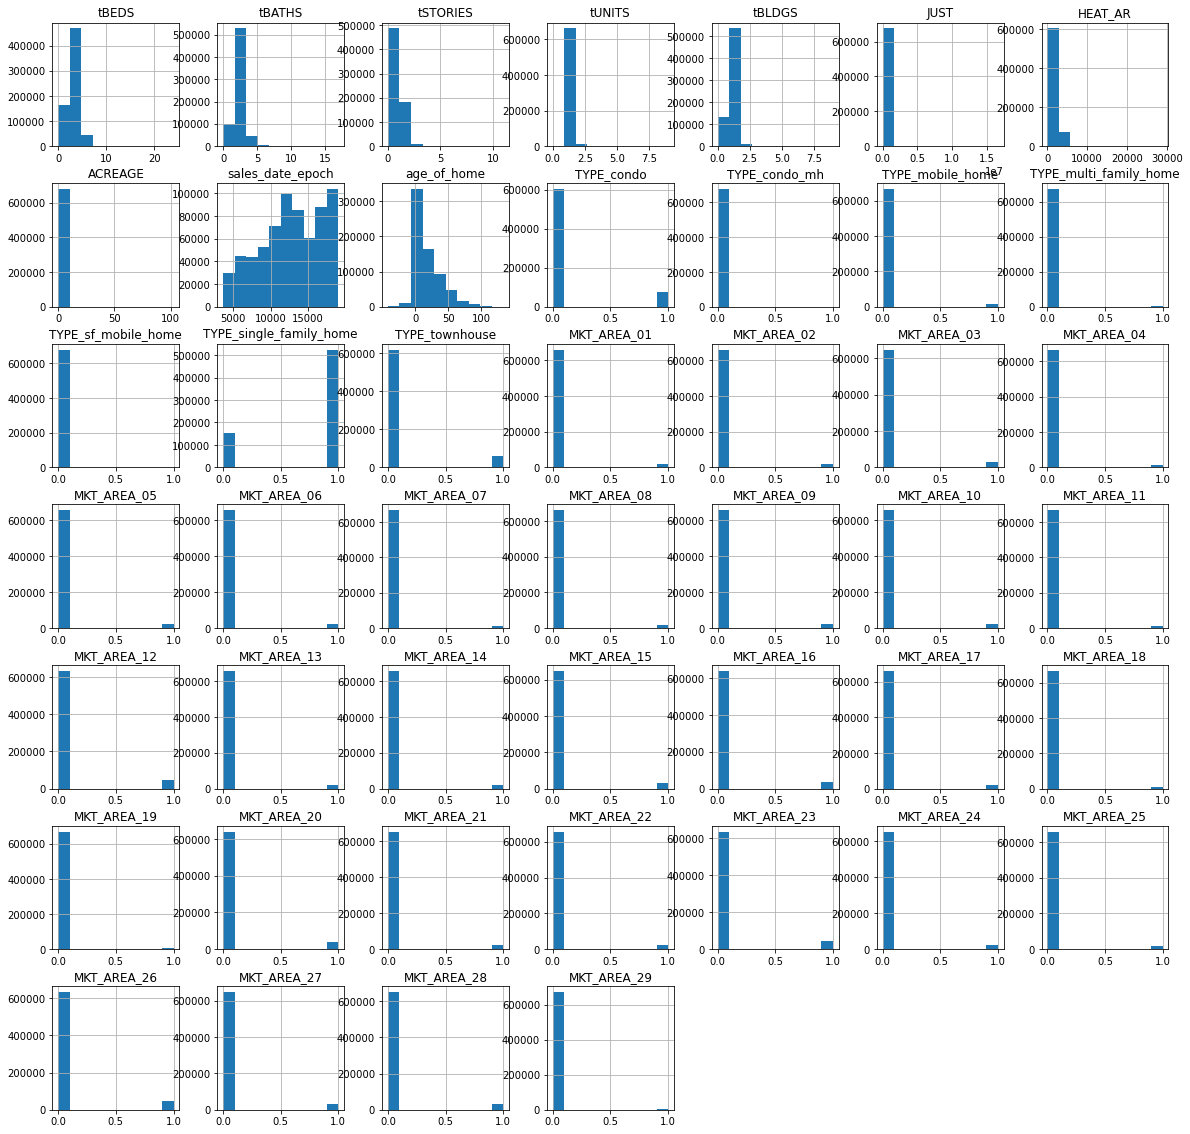

In [23]:
X_train.hist(figsize=(20, 20))
plt.show()

In [12]:
# Save unscaled data to interim data folder as csv files
X_train.to_csv(interim_data + 'X_train.csv', index=False)
X_test.to_csv(interim_data + 'X_test.csv', index=False)
y_train.to_csv(interim_data + 'y_train.csv', index=False)
y_test.to_csv(interim_data + 'y_test.csv', index=False)

# 5 Scale Features<a id='5'></a>

In [13]:
# Apply a standard scaler to the training data
SS_scaler = StandardScaler()
SS_scaler.fit(X_train)
X_train_scaled = SS_scaler.transform(X_train)

In [25]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_train_scaled.head()

,tBEDS,tBATHS,tSTORIES,tUNITS,tBLDGS,JUST,HEAT_AR,ACREAGE,sales_date_epoch,improved,...,MKT_AREA_20,MKT_AREA_21,MKT_AREA_22,MKT_AREA_23,MKT_AREA_24,MKT_AREA_25,MKT_AREA_26,MKT_AREA_27,MKT_AREA_28,MKT_AREA_29
0,-2.185835,-1.564560,-0.588692,-0.100079,0.439502,-0.538063,-1.385322,0.170753,-1.472381,0.243567,...,4.142536,-0.192475,-0.178765,-0.25602,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
1,0.901114,0.993350,-0.588692,-0.100079,0.439502,0.429762,1.086451,-0.118733,1.121112,0.243567,...,-0.241398,-0.192475,-0.178765,-0.25602,-0.190779,5.886470,-0.271528,-0.218301,-0.212794,-0.095187
2,-1.156852,-0.285605,-0.588692,-0.100079,0.439502,-0.077642,-0.470110,0.397580,-1.487423,0.243567,...,-0.241398,-0.192475,-0.178765,-0.25602,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
3,-0.127869,-0.285605,-0.588692,-0.100079,0.439502,-0.072577,-0.205612,0.081986,-0.059425,0.243567,...,-0.241398,-0.192475,-0.178765,-0.25602,-0.190779,-0.169881,-0.271528,4.580837,-0.212794,-0.095187
4,-1.156852,0.353872,1.409851,-0.100079,-1.922451,-0.430948,-0.783763,-0.363758,0.052661,0.243567,...,-0.241398,-0.192475,-0.178765,-0.25602,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187


In [15]:
X_test_scaled = SS_scaler.transform(X_test)

In [26]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
X_test_scaled.head()

,tBEDS,tBATHS,tSTORIES,tUNITS,tBLDGS,JUST,HEAT_AR,ACREAGE,sales_date_epoch,improved,...,MKT_AREA_20,MKT_AREA_21,MKT_AREA_22,MKT_AREA_23,MKT_AREA_24,MKT_AREA_25,MKT_AREA_26,MKT_AREA_27,MKT_AREA_28,MKT_AREA_29
0,-1.156852,0.353872,1.409851,-0.100079,-1.922451,-0.638264,-0.821214,-0.341200,0.508038,0.243567,...,-0.241398,-0.192475,-0.178765,3.905946,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
1,1.930097,1.632827,1.409851,-0.100079,0.439502,0.824804,1.532354,-0.205563,0.946676,0.243567,...,-0.241398,-0.192475,-0.178765,-0.256020,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
2,0.901114,-0.285605,-0.588692,-0.100079,0.439502,-0.630441,-0.660877,-0.227330,0.648024,0.243567,...,-0.241398,-0.192475,-0.178765,-0.256020,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
3,-0.127869,-0.285605,-0.588692,-0.100079,0.439502,-0.185641,-0.089747,-0.212406,-0.006536,0.243567,...,-0.241398,-0.192475,-0.178765,-0.256020,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187
4,1.930097,2.272304,-0.588692,-0.100079,0.439502,1.024141,1.871754,1.431775,-1.258643,-4.105638,...,-0.241398,5.195473,-0.178765,-0.256020,-0.190779,-0.169881,-0.271528,-0.218301,-0.212794,-0.095187


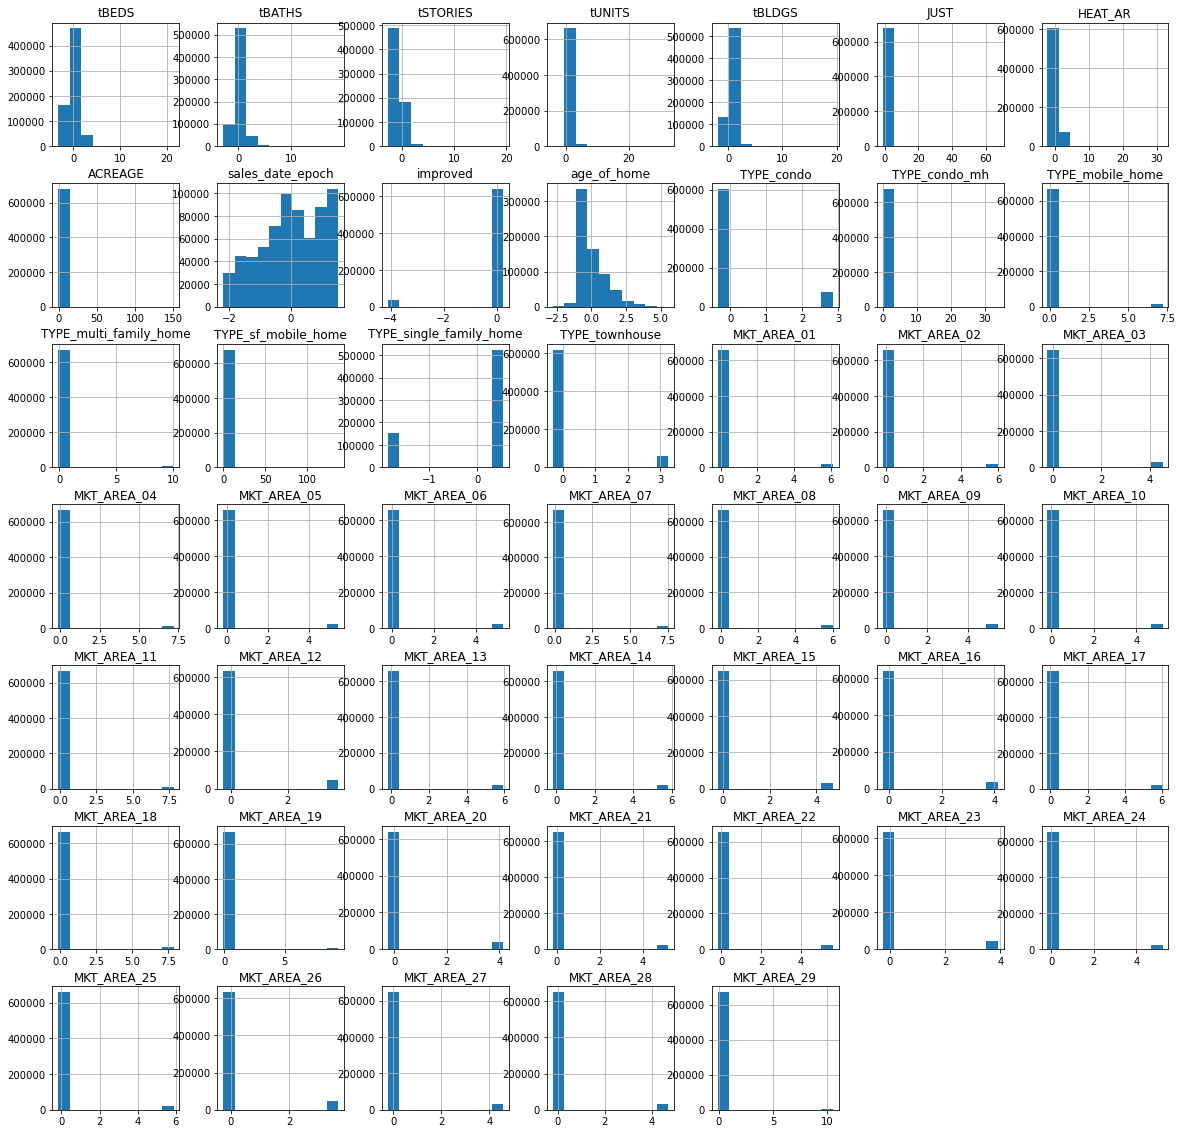

In [27]:
X_train_scaled.hist(figsize=(20, 20))
plt.show()

In [18]:
# Save unscaled data to interim data folder as csv files
X_train_scaled.to_csv(interim_data + 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(interim_data + 'X_test_scaled.csv', index=False)